In [1]:
import sys
sys.path.append(r"C:/Users/laure/OneDrive/Documents/ERDC_FRF/pyCMTB")
sys.path


['C:\\Users\\laure',
 'C:\\Users\\laure\\anaconda3\\python38.zip',
 'C:\\Users\\laure\\anaconda3\\DLLs',
 'C:\\Users\\laure\\anaconda3\\lib',
 'C:\\Users\\laure\\anaconda3',
 '',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\laure\\.ipython',
 'C:/Users/laure/OneDrive/Documents/ERDC_FRF/pyCMTB']

In [2]:
import testbedutils
from objectiveMapping import objMapPrep as omp


['C:\\Users\\laure', 'C:\\Users\\laure\\anaconda3\\python38.zip', 'C:\\Users\\laure\\anaconda3\\DLLs', 'C:\\Users\\laure\\anaconda3\\lib', 'C:\\Users\\laure\\anaconda3', '', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\laure\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\laure\\.ipython', 'C:/Users/laure/OneDrive/Documents/ERDC_FRF/pyCMTB', '/home/spike/repos']


In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


from objectiveMapping.objMapPrep import coarseBackground
from objectiveMapping.objMapPrep import getGeoDatasets
from objectiveMapping.objMapPrep import binMorph
from objectiveMapping.objMapPlots import scatterDEM, pcolorDEM


In [4]:
noise = 0.01    # meters elevation
Lx = 15    # meters cross-shore
Ly = 150    # meters alongshore
countBinThresh = 3  # number of data points required in bin



In [5]:
bg = Dataset('https://chldata.erdc.dren.mil/thredds/dodsC/cmtb/integratedBathyProduct/survey/2020/CMTB-integratedBathyProduct_survey_202001.nc')
x = bg.variables['xFRF'][:]
y = bg.variables['yFRF'][:]
zbg = bg.variables['elevation'][:].squeeze()
xx, yy = np.meshgrid(x, y)

xx = np.ma.masked_where(yy > 4500, xx)
yy = np.ma.masked_where(yy > 4500, yy)
zb = np.ma.masked_where(yy > 4500, zbg)

<ipython-input-5-bc241de80057>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = bg.variables['xFRF'][:]
<ipython-input-5-bc241de80057>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = bg.variables['yFRF'][:]
<ipython-input-5-bc241de80057>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning,

In [6]:
# Now lets reduce to a new coarser grid that will have multiple observations in each bin
# alongshore res ~50m (?)
# crossshore res ~8m (?)
cdx = 50
cdy = 8
xc, yc, zc, xn, yn = coarseBackground(x=x, y=y, z=zbg, cdx=cdx, cdy=cdy)


In [7]:
bathyFile = 'https://chldata.erdc.dren.mil/thredds/dodsC/frf/geomorphology/elevationTransects/survey/2020/FRF_geomorphology_elevationTransects_survey_20200110.nc'
duneFile = 'https://chldata.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/duneLidarDEM/2020/FRF-geomorphology_DEMs_duneLidarDEM_202001.nc'
pierFile = 'https://chldata.erdc.dren.mil/thredds/dodsC/frf/geomorphology/DEMs/pierLidarDEM/2020/FRF-geomorphology_DEMs_pierLidarDEM_202001.nc'
clarisFile = None


In [8]:
getData = getGeoDatasets(bathyFile=bathyFile, pierFile=pierFile, duneFile=duneFile, clarisFile=clarisFile)

bathy = getData.getBathy()
pier = getData.getPier()
dune = getData.getDune()
claris = getData.getClaris()


    Binning took 82.9 s


C:/Users/laure/OneDrive/Documents/ERDC_FRF/pyCMTB\objectiveMapping\objMapPlots.py:399: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc2 = ax3.pcolormesh(x, y, z)


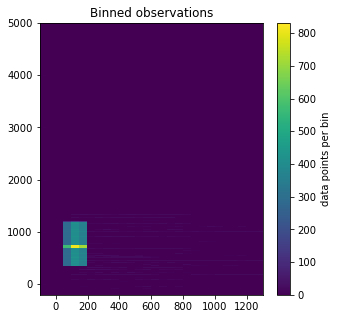

In [9]:
zs = np.ma.concatenate([bathy['z'], dune['z'], pier['z']]) # , claris['z']])
ys = np.ma.concatenate([bathy['y'], dune['y'], pier['y']]) #, claris['y']])
xs = np.ma.concatenate([bathy['x'], dune['x'], pier['x']]) #, claris['x']])

binned = binMorph(xn, yn, xs, ys, zs)

bc = binned['binCounts']
id = np.nonzero(bc > countBinThresh)
bcvals = bc[id]
zbin = binned['zBinVar']
# check standard error to see if noise value you chose is reasonable
stdErr = np.sqrt(zbin[id]/bc[id])
zbM = binned['zBinMedian']
zFluc = zbM[id] - zc[id]


scatterDEM(x=binned['xBinMedian'], y=binned['yBinMedian'], z=binned['zBinMedian'], title="Binned Survey", label='elevation (m)')

pcolorDEM(x=xc, y=yc, z=binned['binCounts'], title="Binned observations", label='data points per bin')

scatterDEM(x=xc[id], y=yc[id], z=stdErr, title='standard error [m]', label='standard error [m]')

scatterDEM(x=xc[id], y=yc[id], z=zFluc, title='Difference between Median Obs and previous map', label='elevation flucuation [m] of binned data', cmap='RdBu')



   beginning mapping function
  8.0 sec elapsed for matrix A
  42.6 sec elapsed for error matrix
  53.7 total time for objective mapping


<ipython-input-10-98b8e3043c53>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc7 = ax7.pcolor(xc, yc, nmseest)
<ipython-input-10-98b8e3043c53>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc8 = ax8.pcolor(xc, yc, mapfluc)
<ipython-input-10-98b8e3043c53>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='

Text(0.5, 1.0, 'Linear interpolation to coarser grid')

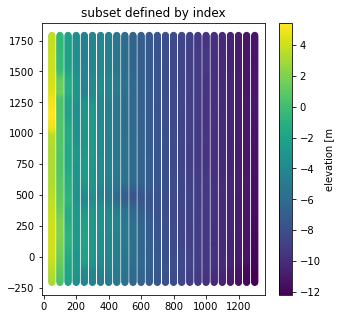

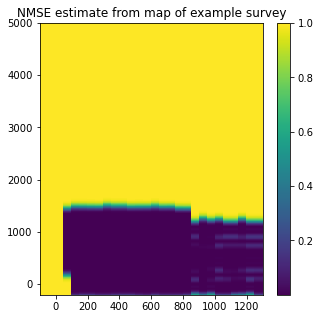

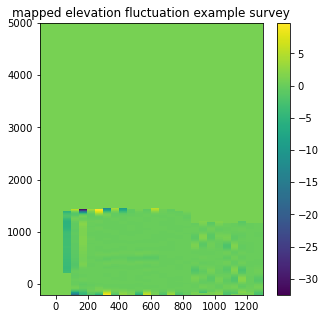

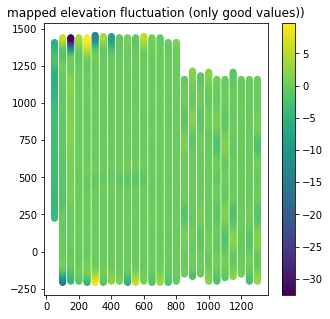

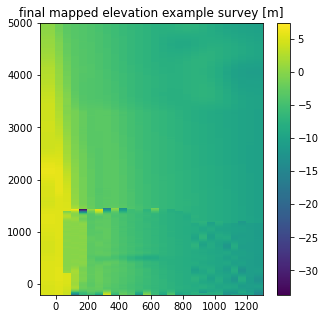

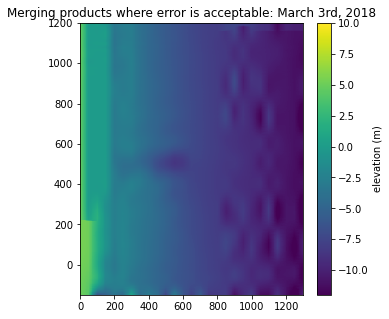

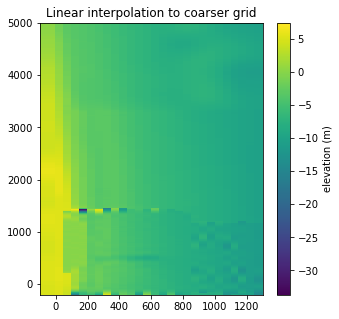

In [10]:
# map example survey
# extract relevant domain for mapping from coarser grid scale
xmin = np.min(xc[id])-Lx*3  # min cross-shore
xmax = np.max(xc[id])+Lx*3  # max cross-shore
ymin = np.min(yc[id])-Ly*3  # min alongshore
ymax = np.max(yc[id])+Ly*3  # max alongshore
idInt = np.where((xc > xmin) & (xc < xmax) & (yc > ymin) & (yc < ymax))

# checking the index created
fig6, ax6 = plt.subplots(1, 1, figsize=(5, 5))
sc6 = ax6.scatter(xc[idInt], yc[idInt], c=zc[idInt])
#sc6 = ax6.scatter(xx[idInt], yy[idInt], c=zbg[idInt])

cbar = plt.colorbar(sc6, ax=ax6)
cbar.set_label('elevation [m')
ax6.set_title('subset defined by index')


from objectiveMapping.objMapInterp import map_interp

dgcov, dcovE, A, Aprime, mapFluc, nmseEst, dcovA, dcovA2, sigVar = map_interp(x=xc[id], y=yc[id], zFluc=zFluc, noise=noise, Lx=Lx, Ly=Ly, xInt=xc[idInt], yInt=yc[idInt])
#dgcov, dcovE, A, Aprime, mapFluc, nmseEst, dcovA, dcovA2, sigVar = map_interp(x=xc[cellIDsAboveBinThresh], y=yc[cellIDsAboveBinThresh], zFluc=zFluc, noise=noise, Lx=Lx, Ly=Ly, xInt=xx[idInt], yInt=yy[idInt])

allzeros = np.ones(xc.shape)
nmseest = np.ones(xc.shape)
nmseest[idInt] = nmseEst.T
mapfluc = np.zeros(xc.shape)
mapfluc[idInt] = mapFluc
goodi = np.nonzero(nmseest < .2)
badi = np.nonzero(nmseest > .2)
mapfluc[badi] = allzeros[badi]

mapz = mapfluc+zc

# look at error estimates
fig7, ax7 = plt.subplots(1, 1, figsize=(5, 5))
sc7 = ax7.pcolor(xc, yc, nmseest)
cbar = plt.colorbar(sc7, ax=ax7)
#cbar.set_label('elevation [m')
ax7.set_title('NMSE estimate from map of example survey')

# look at error estimates
fig8, ax8 = plt.subplots(1, 1, figsize=(5, 5))
sc8 = ax8.pcolor(xc, yc, mapfluc)
cbar = plt.colorbar(sc8, ax=ax8)
#cbar.set_label('elevation [m')
ax8.set_title('mapped elevation fluctuation example survey')


# look at error estimates
fig9, ax9 = plt.subplots(1, 1, figsize=(5, 5))
sc8 = ax9.scatter(xc[goodi], yc[goodi], c=mapfluc[goodi])
cbar = plt.colorbar(sc8, ax=ax9)
#cbar.set_label('elevation [m')
ax9.set_title('mapped elevation fluctuation (only good values))')

# look at the final map produced
fig10, ax10 = plt.subplots(1, 1, figsize=(5, 5))
sc10 = ax10.pcolor(xc, yc, mapz)
cbar = plt.colorbar(sc10, ax=ax10)
#cbar.set_label('elevation [m')
ax10.set_title('final mapped elevation example survey [m]')

# now lets interpolate these accepted values to the 5 x 5 m grid



xgood = xc.flatten()
ygood = yc.flatten()
points = np.vstack([xgood, ygood])
points = points.T
zgood = mapz.flatten()

fi = interpolate.griddata(points=points, values=zgood, xi=(xx, yy), method='linear')


#zcfi = fi(xc, yc)
fig10, ax11 = plt.subplots(1, 1, figsize=(5, 5))
sc2 = ax11.pcolor(xx, yy, fi, vmin=-12, vmax=10)
cbar2 = plt.colorbar(sc2, ax=ax11)
cbar2.set_label("elevation (m)")
ax11.set_title("Merging products where error is acceptable: March 3rd, 2018")
ax11.set_xlim([0, 1300])
ax11.set_ylim([-150, 1200])



fig13, ax13 = plt.subplots(1, 1, figsize=(5, 5))

f2 = interpolate.interp2d(x, y, fi, kind='linear')
zc2 = f2(xn, yn)
sc2 = ax13.pcolor(xc, yc, zc2)
cbar2 = plt.colorbar(sc2, ax=ax13)
cbar2.set_label("elevation (m)")
ax13.set_title("Linear interpolation to coarser grid")







    Binning took 10.9 s
   beginning mapping function
  6.0 sec elapsed for matrix A
  35.6 sec elapsed for error matrix
  43.4 total time for objective mapping


<ipython-input-12-1cb9d51dca52>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc8 = ax9.pcolor(xc, yc, mapfluc2, vmin=-3, vmax=3, cmap='RdBu')
<ipython-input-12-1cb9d51dca52>:76: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc2 = ax13.pcolor(xc, yc, zc3)


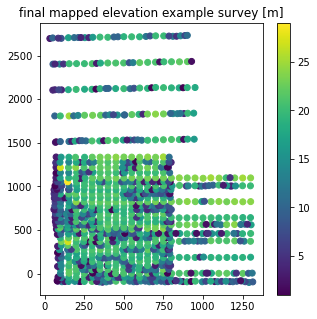

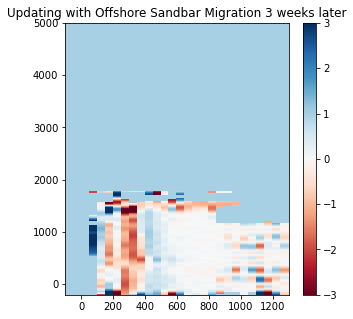

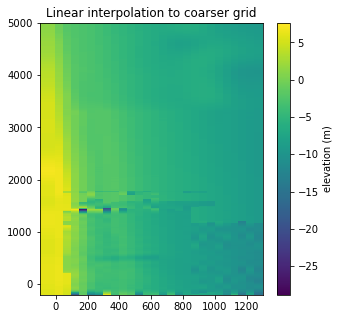

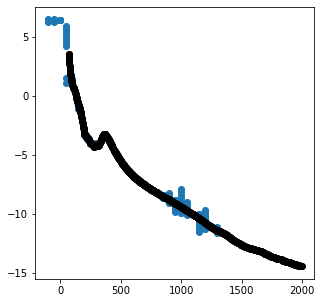

In [12]:
bathyFile = 'https://chldata.erdc.dren.mil/thredds/dodsC/frf/geomorphology/elevationTransects/survey/data/FRF_geomorphology_elevationTransects_survey_20180315.nc'
getData = getGeoDatasets(bathyFile=bathyFile, pierFile=None, duneFile=None, clarisFile=None)

bathy2 = getData.getBathy()
zs2 = bathy2['z']
ys2 = bathy2['y']
xs2 = bathy2['x']


binned2 = binMorph(xn, yn, xs2, ys2, zs2)
zbM2 = binned2['zBinMedian']
bc2 = binned2['binCounts']
id2 = np.nonzero(bc2 > countBinThresh)

zFluc2 = zbM2[id2] - zc2[id2]



fig12, ax12 = plt.subplots(1, 1, figsize=(5, 5))
#sc10 = ax12.scatter(xs2, ys2, c=zs2)
#sc10 = ax12.scatter(binned2['xBinMedian'], binned2['yBinMedian'], c=binned2['zBinMedian'])
#sc10 = ax12.scatter(xc[id2], yc[id2], c=zbM2[id2])
#sc10 = ax12.scatter(xc[id2], yc[id2], c=zc2[id2])
#sc10 = ax12.scatter(binned2['xBinMedian'], binned2['yBinMedian'], c=zFluc2)
sc10 = ax12.scatter(binned2['xBinMedian'], binned2['yBinMedian'], c=binned2['binCounts'])


#sc10 = ax12.scatter(xc[id2], yc[id2], c=zFluc2)

cbar = plt.colorbar(sc10, ax=ax12)
#cbar.set_label('elevation [m')
ax12.set_title('final mapped elevation example survey [m]')





dgcov, dcovE, A, Aprime, mapFluc2, nmseEst, dcovA, dcovA2, sigVar = map_interp(x=xc[id2], y=yc[id2], zFluc=zFluc2, noise=noise, Lx=Lx, Ly=Ly, xInt=xc[idInt], yInt=yc[idInt])



allzeros = np.ones(xc.shape)
nmseest2 = np.ones(xc.shape)
nmseest2[idInt] = nmseEst.T
mapfluc2 = np.zeros(xc.shape)
mapfluc2[idInt] = mapFluc2
goodi2 = np.nonzero(nmseest2 < .2)
badi2 = np.nonzero(nmseest2 > .2)
mapfluc2[badi2] = allzeros[badi2]

mapz2 = mapfluc2+zc2


# look at error estimates
fig9, ax9 = plt.subplots(1, 1, figsize=(5, 5))
sc8 = ax9.pcolor(xc, yc, mapfluc2, vmin=-3, vmax=3, cmap='RdBu')
cbar = plt.colorbar(sc8, ax=ax9)
#cbar.set_label('elevation [m')
ax9.set_title('Updating with Offshore Sandbar Migration 3 weeks later')




xgood = xc.flatten()
ygood = yc.flatten()
points = np.vstack([xgood, ygood])
points = points.T
zgood = mapz2.flatten()
#zgood = mapfluc2.flatten()

fi2 = interpolate.griddata(points=points, values=zgood, xi=(xx, yy), method='linear')
f3 = interpolate.interp2d(x, y, fi2, kind='linear')
zc3 = f3(xn, yn)

fig13, ax13 = plt.subplots(1, 1, figsize=(5, 5))
sc2 = ax13.pcolor(xc, yc, zc3)
cbar2 = plt.colorbar(sc2, ax=ax13)
cbar2.set_label("elevation (m)")
ax13.set_title("Linear interpolation to coarser grid")


# compare to survey
# get a subset of the yc
transect = np.where((yc > 1050) & (yc < 1150))
fig12, ax12 = plt.subplots(1, 1, figsize=(5, 5))
sc10 = ax12.scatter(xc[transect], zc3[transect])

realtransect = np.where((ys2 > 1050) & (ys2 < 1150))
sc10b = ax12.scatter(xs2[realtransect], zs2[realtransect], c='k')







#zs = np.ma.concatenate([bathy['z'], dune['z'], pier['z'], claris['z']])
#ys = np.ma.concatenate([bathy['y'], dune['y'], pier['y'], claris['y']])
#xs = np.ma.concatenate([bathy['x'], dune['x'], pier['x'], claris['x']])



